In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyvinecopulib as pv

from fastkde import fastkde
from scipy.optimize import curve_fit
from scipy.stats import gaussian_kde, ks_2samp, norm, rankdata

In [2]:
# Load data
df = pd.read_excel("data_flowdike.xlsx")

# Select data with hpeak > 1cm
df = df[df['hpeak'] >= 0.01]

# Match colors
colors = ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple", "tab:brown", "tab:pink", "tab:cyan"]
conv_dict = {expid:c for expid, c in zip(list(np.unique(df['experiment_id'])), colors)}
df['color'] = df['experiment_id'].map(conv_dict)

# Calculate dimensionless values
df['upeakd'] = df['upeak'] / np.sqrt(9.81 * df['Hm0'])
df['hpeakd'] = df['hpeak'] / df['Hm0']
df['vtd'] = df['vt'] / df['Hm0']**2

# Curve
def curve_exp(x, a, b):
    return a * x ** b

# Calculate residuals per experiment
for expid, _df in df.groupby(by="experiment_id"):

    # Fit curve
    paramu, _ = curve_fit(curve_exp, _df['vtd'], _df['upeakd'])
    paramh, _ = curve_fit(curve_exp, _df['vtd'], _df['hpeakd'])
    
    # Marginals
    ru = np.log(_df['upeakd']) - np.log(curve_exp(_df['vtd'], *paramu))
    rh = np.log(_df['hpeakd']) - np.log(curve_exp(_df['vtd'], *paramh))
    
    # Adjust
    muu, _ = norm.fit(ru)
    muh, _ = norm.fit(rh)

    # Calculate residuals
    df.loc[df['experiment_id'] == expid, 'ru'] = np.log(_df['upeakd']) - np.log(curve_exp(_df['vtd'], *paramu)) - muu
    df.loc[df['experiment_id'] == expid, 'rh'] = np.log(_df['hpeakd']) - np.log(curve_exp(_df['vtd'], *paramh)) - muh

# Determine generalized distributions
for cota, deeldf in df.groupby(by="cota"):
    _, sigma = norm.fit(deeldf['ru'])
    df.loc[df["cota"] == cota, "gen_sigma_u"] = sigma

_, sigma_h = norm.fit(df['rh'])
df.loc[:, "gen_sigma_h"] = sigma_h

<h1>5 - Generalized Model to Describe Variation</h1>

<h3>Comparison between the residuals $r_{u}$ and $r_{h}$ from the FlowDike experiments, and the generalized model</h3>

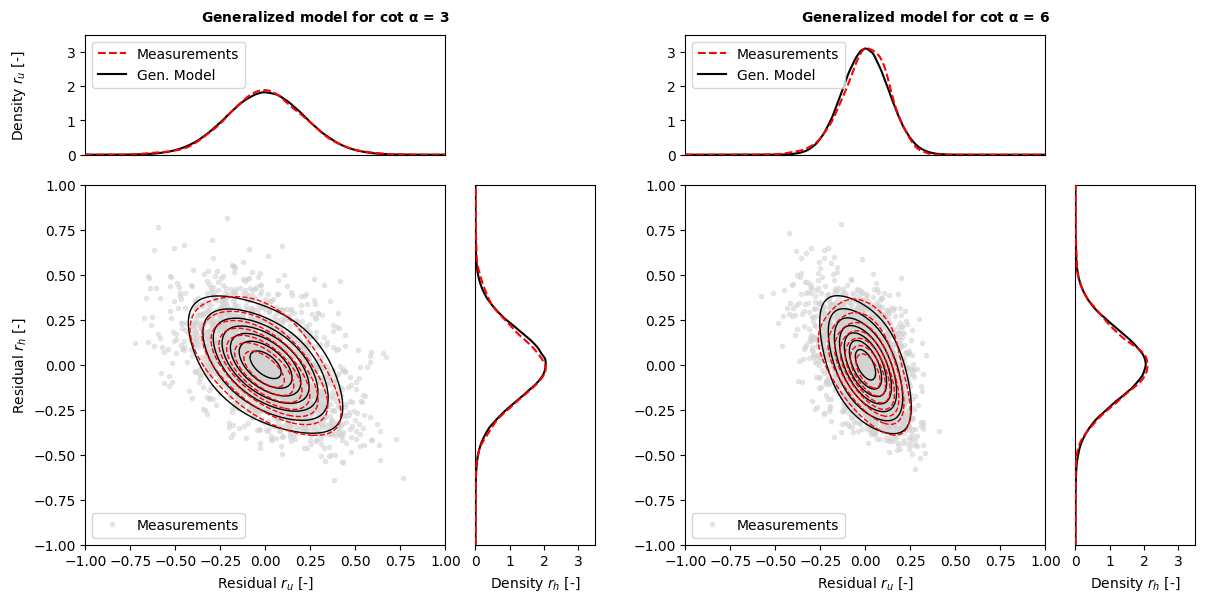

In [4]:
# Samples
n_samples = 1_000_000

# Plot
fig = plt.figure(figsize=(12, 6))

# Create axes
ax_main = [fig.add_axes([0.05, 0.1, 0.3, 0.6]), fig.add_axes([0.55, 0.1, 0.3, 0.6])]
ax_top = [fig.add_axes([0.05, 0.75, 0.3, 0.2]), fig.add_axes([0.55, 0.75, 0.3, 0.2])]
ax_right = [fig.add_axes([0.375, 0.1, 0.1, 0.6]), fig.add_axes([0.875, 0.1, 0.1, 0.6])]

# Fill in
i = 0
for cota, deeldf in df.groupby(by="cota"):
    
    # Get axis
    axm = ax_main[i]
    axt = ax_top[i]
    axr = ax_right[i]
    
    # Plot data
    axm.plot(deeldf['ru'], deeldf['rh'], ".", color="lightgrey", alpha=0.5, label="Measurements")
    
    # Plot data PDF on top and right axis
    _x = np.linspace(-1, 1, 1000)
    axt.plot(_x, gaussian_kde(deeldf['ru'])(_x), "--", color="red", label="Measurements", zorder=3)
    axr.plot(gaussian_kde(deeldf['rh'])(_x), _x, "--", color="red", label="Measurements", zorder=3)
    pdfe = gaussian_kde([deeldf['ru'], deeldf['rh']]).pdf([deeldf['ru'], deeldf['rh']])
    
    # Create a copula and fit data
    data = np.array([rankdata(deeldf['ru'])/ (len(deeldf['ru']) + 1), rankdata(deeldf['rh'])/ (len(deeldf['rh']) + 1)]).T
    cop = pv.Bicop.from_family(pv.BicopFamily.student, parameters=np.array([[-0.497], [9.361]]))

    # Monte Carlo
    cu, ch = cop.simulate(n_samples).T  # Copula samples
    xu = norm(0, deeldf['gen_sigma_u'].iloc[0]).ppf(cu)  # Transform to normal
    xh = norm(0, deeldf['gen_sigma_h'].iloc[0]).ppf(ch)

    # Density points
    kde_p = fastkde.pdf(deeldf['ru'].to_numpy(), deeldf['rh'].to_numpy(), var_names = ['xu', 'xh'])
    kde = fastkde.pdf(xu, xh, var_names = ['xu', 'xh'])
    
    # Compute density on a grid
    _levels = np.sort(np.linspace(np.max([np.max(kde.to_numpy()), np.max(kde_p.to_numpy())]), 0, 8, endpoint=False))
    _ = axm.contour(kde_p.xu, kde_p.xh, kde_p.to_numpy(), levels=_levels, colors='red', linewidths=1, linestyles="--", vmin=3, zorder=3)
    contour = axm.contour(kde.xu, kde.xh, kde.to_numpy(), levels=_levels, colors='black', linewidths=1, vmin=3)
    
    # Plot copula PDF on the top and right axis
    axt.plot(_x, gaussian_kde(xu)(_x), color="black", label="Gen. Model")
    axr.plot(gaussian_kde(xh)(_x), _x, color="black", label="Gen. Model")

    # Increase i by 1
    i += 1

# Legend to main
[ax.legend(loc="lower left", prop={'size': 10}) for ax in ax_main]
[ax.legend(loc="upper left") for ax in ax_top]
    
# Remove xticks
[ax.get_xaxis().set_visible(False) for ax in ax_top]
[ax.get_yaxis().set_visible(False) for ax in ax_right]

# Set xlim / ylim
[ax.set_xlim(-1, 1) for ax in ax_main]
[ax.set_ylim(-1, 1) for ax in ax_main]
[ax.set_xlim(-1, 1) for ax in ax_top]
[ax.set_ylim(0, 3.5) for ax in ax_top]
[ax.set_xlim(0, 3.5) for ax in ax_right]
[ax.set_ylim(-1, 1) for ax in ax_right]

# Set xticks / yticks
[ax.set_yticks([0, 1, 2, 3]) for ax in ax_top]
[ax.set_xticks([0, 1, 2, 3]) for ax in ax_right]

# Set xlabel / ylabel
[ax.set_xlabel(r"Residual $r_{u}$ [-]") for ax in ax_main]
[ax.set_xlabel(r"Density $r_{h}$ [-]") for ax in ax_right]
ax_main[0].set_ylabel(r"Residual $r_{h}$ [-]")
ax_top[0].set_ylabel(r"Density $r_{u}$ [-]", labelpad=28)

fig.text(0.25, 0.98, r"Generalized model for cot $\mathbf{\alpha}$ = 3", ha="center", va="center", fontsize=10, fontweight="bold")
fig.text(0.75, 0.98, r"Generalized model for cot $\mathbf{\alpha}$ = 6", ha="center", va="center", fontsize=10, fontweight="bold")

# Finish
fig.align_labels()
plt.show()